In [1]:
import numpy as np
from matplotlib import pyplot as plt
import sys
import math
from mpl_toolkits import mplot3d
from pylab import rcParams
from tqdm import tqdm
rcParams['figure.figsize'] = 15, 15

### Plot Functions

In [2]:
def plot_data(data_1, data_2, label_1, label_2, markersize_1=8, markersize_2=8):
    ax = plt.axes(projection='3d')
    ax.scatter3D(data_1[0,:], data_1[1,:], data_1[2,:], color='#336699', label=label_1)
    ax.scatter3D(data_2[0,:], data_2[1,:], data_2[2,:], color='orangered', label=label_2)
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_zlabel('Z-axis')
    ax.legend()
    return ax

In [3]:
def plot_values(values, label):
    fig = plt.figure(figsize=(10, 4))
    ax = fig.add_subplot(111)
    ax.plot(values, label=label)
    ax.legend()
    ax.grid(True)
    plt.show()

In [4]:
def draw_correspondences(P, Q, correspondences, ax):
    label_added = False
    for i, j in correspondences:
        x = [P[0, i], Q[0, j]]
        y = [P[1, i], Q[1, j]]
        z = [P[2, i], Q[2, j]]
        if not label_added:
            ax.plot(x, y, zs=z, color='grey', label='correpondences')
            label_added = True
        else:
            ax.plot(x, y, zs=z, color='grey')
    ax.legend()

### Random Rotation and Translation

In [5]:
theta = math.pi / 3
c, s = np.cos(theta), np.sin(theta)

S = 3 * np.identity(3)

R_act = np.array(
                    [[c, -s, 0],[s, c, 0], [0, 0, 1]]
                )
t_act = np.array([[-5],[6], [7]])

### Mean Centering

In [6]:
def mean_center(S, exclude_indices=[]):
    reduced_data = np.delete(S, exclude_indices, axis=1)
    center = np.array(reduced_data.mean(axis=1)).T
    return center, S - center.reshape(3,1)

### Cross Covariance Matrix

In [7]:
def compute_cross_covariance(P, Q, correspondences, kernel=lambda diff: 1.0):
    cov = np.zeros((3, 3))
    exclude_indices = []
    for i, j in correspondences:
        p_point = P[:, [i]]
        q_point = Q[:, [j]]
        weight = kernel(p_point - q_point)
        if weight < 0.01: exclude_indices.append(i)
        cov += weight * q_point.dot(p_point.T)
    return cov, exclude_indices

### Kd tree correspondences

In [8]:
from sklearn.neighbors import KDTree

def kd_tree_correspondences(point_set_p, point_set_q):
    tree = KDTree(point_set_q.T)
    dist, ind = tree.query(point_set_p.T)
    correspondences = [(i, ind[i][0]) for i in range(point_set_p.T.shape[0])]
    return correspondences

### ICP scale Invariant

In [30]:
def find_alignment(P, Q, correspondences):
    dim_p, p_size = P.shape
    dim_q, q_size = Q.shape
    
    Y = np.zeros((3, p_size))
    
    for i in range(p_size):
        Y[:, i] = Q[:, correspondences[i][1]]
    
    mean_p, mean_y = np.mean(P, axis=1), np.mean(Y, axis=1)
    
    _mean_centerd_p, _mean_centerd_y = P - mean_p.reshape(3,1), Y - mean_y.reshape(3, 1)
    
    
    Px, Py, Pz = _mean_centerd_p[0, :], _mean_centerd_p[1, :], _mean_centerd_p[2, :]
    Yx, Yy, Yz = _mean_centerd_y[0, :], _mean_centerd_y[1, :], _mean_centerd_y[2, :]
    
    Sxx, Sxy, Sxz = Px.dot(Yx), Px.dot(Yy), Px.dot(Yz)
    Syx, Syy, Syz = Py.dot(Yx), Py.dot(Yy), Py.dot(Yz)
    Szx, Szy, Szz = Pz.dot(Yx), Pz.dot(Yy), Pz.dot(Yz)

    N_matrix = np.array([
        [Sxx + Syy + Szz, Syz - Szy, Szx - Sxz, Sxy - Syx],
        [Syz - Szy, Sxx - Szz - Syy, Sxy + Syx, Sxz + Szx],
        [Szx - Sxz, Syx + Sxy, Syy - Sxx - Szz, Syz + Szy],
        [Sxy - Syx, Szx + Sxz, Szy + Syz, Szz - Syy - Sxx]
    ])
    
    L, V = np.linalg.eig(N_matrix)
    
    max_l = np.where(L == np.amax(L))[0][0]
    
    q = V[:, max_l] ##min eigen vector
    
    q0, q1, q2, q3 = q[0], q[1], q[2], q[3]
    
    Q_bar = np.array([
        [q0, -q1, -q2, -q3],
        [q1, q0, q3, -q2],
        [q2, -q3, q0, q1],
        [q3, q2, -q1, q0]
    ])
    
    Q = np.array([
        [q0, -q1, -q2, -q3],
        [q1, q0, -q3, q2],
        [q2, q3, q0, -q1],
        [q3, -q2, q1, q0]
    ])
    
    R = Q_bar.T.dot(Q)[1:4,1:4]
    
    Sp, D = 0, 0
    
    for i in range(p_size):
        D += _mean_centerd_y[:, i].T.dot(_mean_centerd_y[:, i])
        Sp += _mean_centerd_p[:, i].T.dot(_mean_centerd_p[:, i])
    
    
    s = math.sqrt(math.sqrt(D / Sp))
    
    t = mean_y.reshape(3, 1) - s * R.dot(mean_p.reshape(3, 1))
    
    err = 0
    for i in range(p_size):
        d = Y[:, i].reshape(3,1) - s * R.dot(P[:, i].reshape(3,1)) - t
        err += d.T.dot(d)
    
    return s, R, t, err



def icp_scale_invarant(M, P, iterations=10, kernel=lambda diff: 1.0):
    s = None
    R = None
    t = None
    new_p = P.copy()
    
    p_size, m_size = P.shape[1], M.shape[1]
    dim = P.shape[0]
    
    err_list = []    
    
    for itr in tqdm( range(iterations), desc ="Iteration"):
        correspondences = kd_tree_correspondences(new_p, M)
        s, R, t, err = find_alignment(new_p, M, correspondences)
        
        new_p = s*R.dot(new_p) + t.reshape(3,1)
        
        for corr in correspondences:
            err += np.linalg.norm(new_p[:, corr[0]] - M[:, corr[1]])**2
        
        err = err/p_size
        err_list.append(err)
        
        if err < 1e-5:#threshold
            break

    return new_p, err_list
            
        

In [31]:
def icp_svd(P, Q, iterations=10, kernel=lambda diff: 1.0):
    """Perform ICP using SVD."""
    center_of_Q, Q_centered = mean_center(Q)
    norm_values = []
    P_values = [P.copy()]
    P_copy = P.copy()
    corresp_values = []
    exclude_indices = []
    for i in tqdm( range(iterations), desc ="Iteration"):
        center_of_P, P_centered = mean_center(P_copy, exclude_indices=exclude_indices)
        correspondences = kd_tree_correspondences(P_centered, Q_centered)
        corresp_values.append(correspondences)
        norm_values.append(np.linalg.norm(P_centered - Q_centered))
        cov, exclude_indices = compute_cross_covariance(P_centered, Q_centered, correspondences, kernel)
        U, S, V_T = np.linalg.svd(cov)
        R = U.dot(V_T)
        t = center_of_Q - R.dot(center_of_P)
        P_copy = R.dot(P_copy) + t.reshape(3, 1)
        P_values.append(P_copy)
    corresp_values.append(corresp_values[-1])
    return P_values, norm_values, corresp_values

### Random Point set generation P, Q

### 100 points

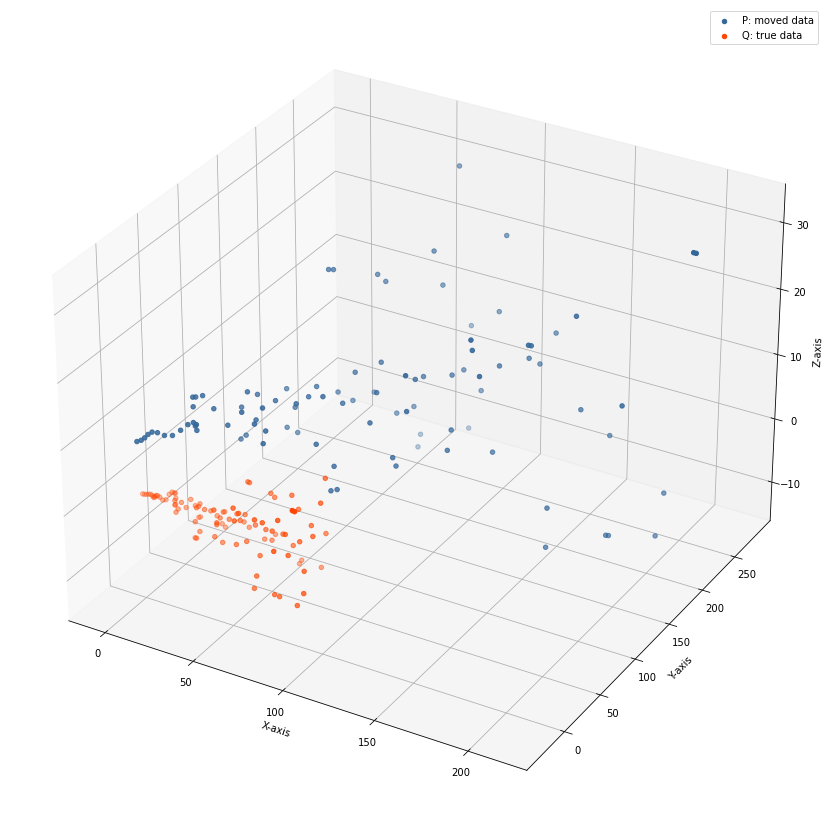

In [32]:
num_points = 100
Q = np.zeros((3, num_points))
Q[0, :] = range(0, num_points)
Q[1, :] = .3 * Q[0, :] * np.sin(.5 * Q[0, :])
Q[2, :] = .3 * Q[1, :] * np.sin(.5 * Q[1, :])

P = S.dot(R_act.dot(Q)) + t_act  # moved data

plot_data(P, Q, "P: moved data", "Q: true data")
plt.ioff()
plt.show()

#### ICP

Iteration: 100%|██████████| 100/100 [00:00<00:00, 769.06it/s]


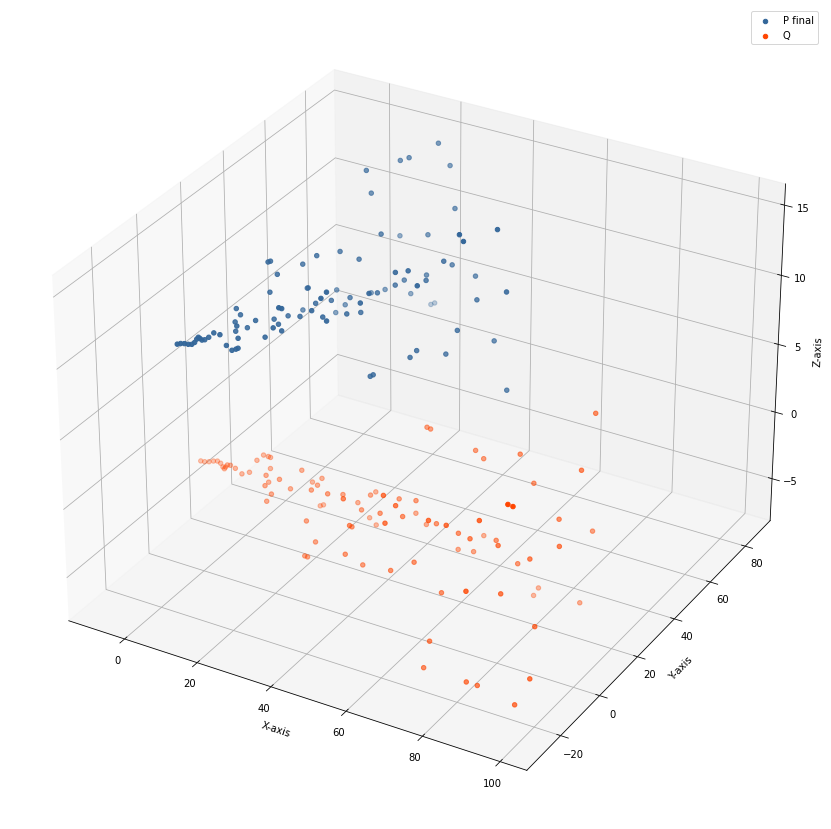

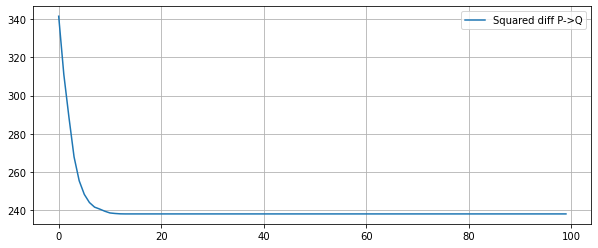

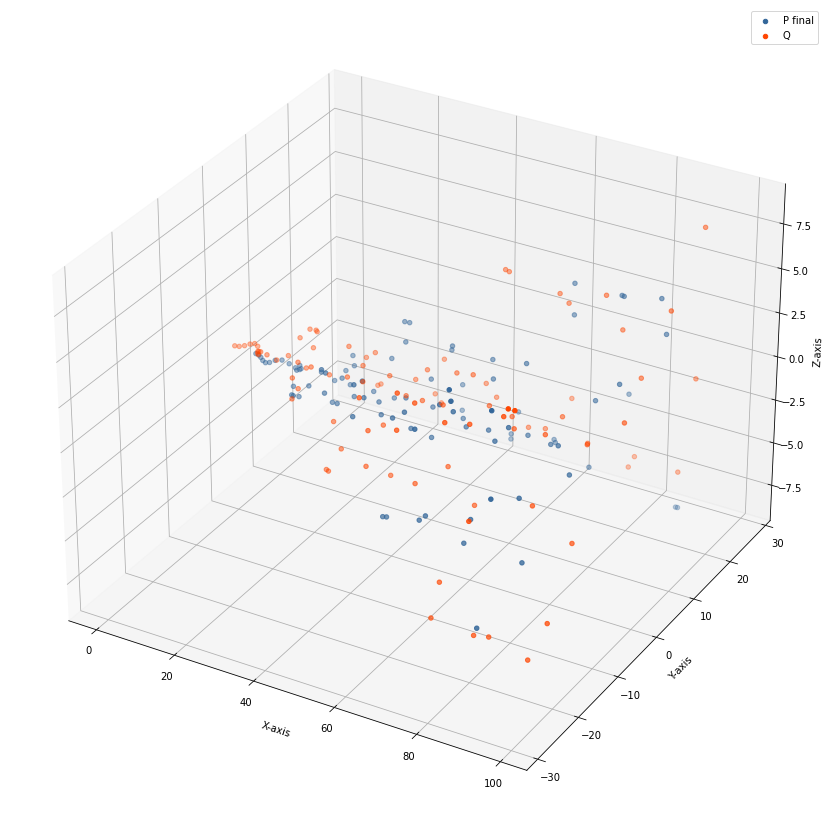

[341.6016250994285, 311.1143206357021, 288.6416388971865, 267.8185440522725, 255.32061710713717, 248.16326298149457, 243.90421014573656, 241.48828519907008, 240.4734622207877, 239.33781580845445, 238.4349413291156, 238.15370031862784, 237.97309975796648, 237.92629277058484, 237.9262927705848, 237.92629277058484, 237.92629277058478, 237.92629277058475, 237.92629277058472, 237.92629277058467, 237.9262927705847, 237.9262927705847, 237.92629277058467, 237.92629277058467, 237.92629277058464, 237.92629277058464, 237.92629277058464, 237.92629277058464, 237.92629277058464, 237.92629277058464, 237.92629277058464, 237.92629277058464, 237.92629277058464, 237.92629277058464, 237.92629277058464, 237.92629277058464, 237.92629277058464, 237.92629277058464, 237.92629277058464, 237.92629277058464, 237.92629277058464, 237.92629277058464, 237.92629277058464, 237.92629277058464, 237.92629277058464, 237.92629277058464, 237.92629277058464, 237.92629277058464, 237.92629277058464, 237.92629277058464, 237.9262

In [34]:
P_values, norm_values = icp_scale_invarant(P, Q, iterations=100)
ax = plot_data(P_values, Q, label_1='P final', label_2='Q', markersize_1=15)
p_values , n, c = icp_svd(P_values, Q, iterations=100)
plot_values(n, label="Squared diff P->Q")
ax = plot_data(p_values[-1], Q, label_1='P final', label_2='Q', markersize_1=15)
plt.show()
print(n)

### 10000 points

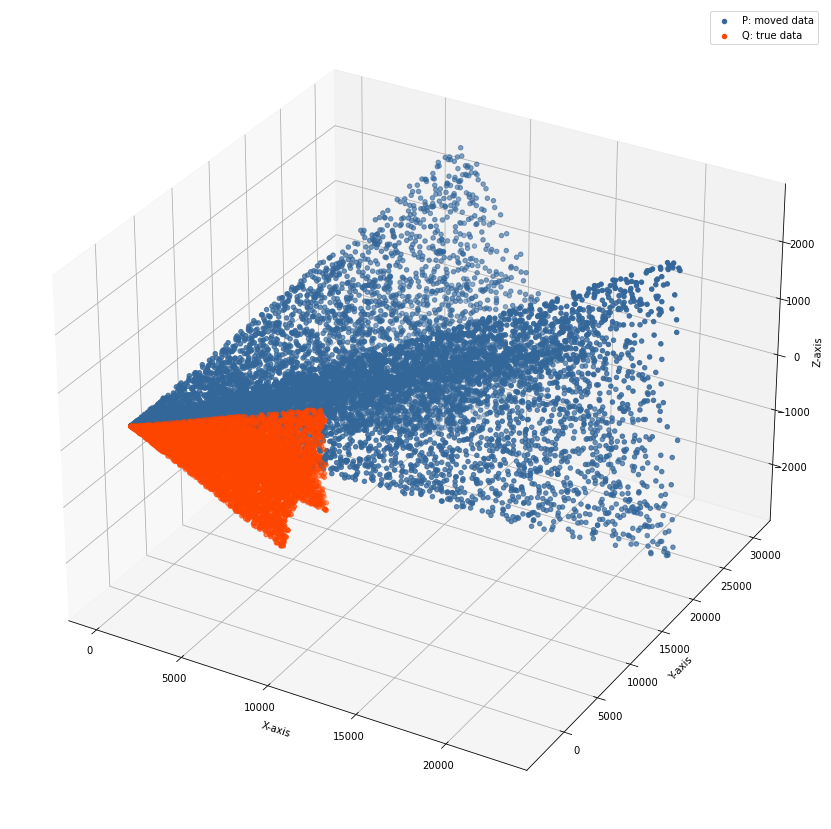

In [35]:
num_points = 10000
Q = np.zeros((3, num_points))
Q[0, :] = range(0, num_points)
Q[1, :] = .3 * Q[0, :] * np.sin(.5 * Q[0, :])
Q[2, :] = .3 * Q[1, :] * np.sin(.5 * Q[1, :])

P = S.dot(R_act.dot(Q)) + t_act  # moved data

plot_data(P, Q, "P: moved data", "Q: true data")
plt.ioff()
plt.show()

#### ICP

Iteration: 100%|██████████| 100/100 [00:21<00:00,  4.65it/s]


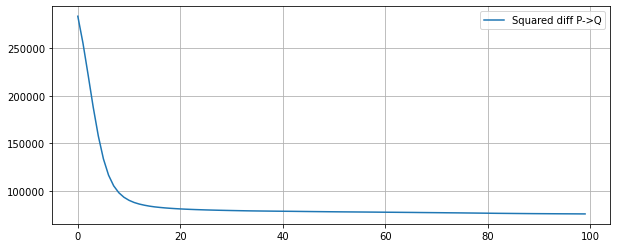

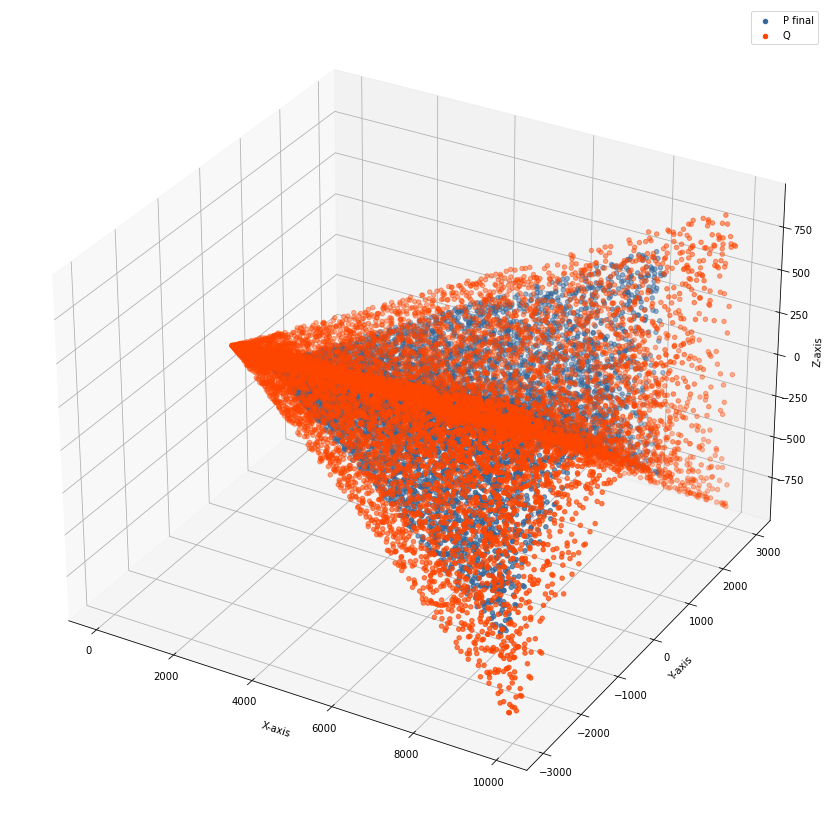

[283633.3587840094, 255473.79239873996, 222249.1382949488, 188072.43008894342, 157588.88885404172, 133407.85981348463, 116316.53007563137, 105092.54629470594, 97841.58361757138, 93068.1247565618, 89820.88509534654, 87536.44204314846, 85892.62298298856, 84676.46655713952, 83687.71265633008, 82927.47906826378, 82354.85352527052, 81855.60572599807, 81443.9199429312, 81091.14580507851, 80782.60866172529, 80519.95359291391, 80290.37469574448, 80080.4927537744, 79902.70357829706, 79732.90605547461, 79582.8500152035, 79447.97621279763, 79320.63093472822, 79202.13777556397, 79086.13422736719, 78980.92515339293, 78878.39568656933, 78781.10779033069, 78700.36835279664, 78629.23506310215, 78566.45923067682, 78504.58725868969, 78445.96727141111, 78385.77476070217, 78334.87817876786, 78284.38495634773, 78230.76532496273, 78166.78330852832, 78104.08619139799, 78039.86678756967, 77981.20387526279, 77927.39510495854, 77870.2972237358, 77814.45439271603, 77762.46151492232, 77712.00766338894, 77665.8942

In [36]:
P_values, norm_values = icp_scale_invarant(P, Q, iterations=100)
p_values , n, c = icp_svd(P_values, Q, iterations=100)
plot_values(n, label="Squared diff P->Q")
ax = plot_data(p_values[-1], Q, label_1='P final', label_2='Q', markersize_1=15)
plt.show()
print(n)

### 100000 points

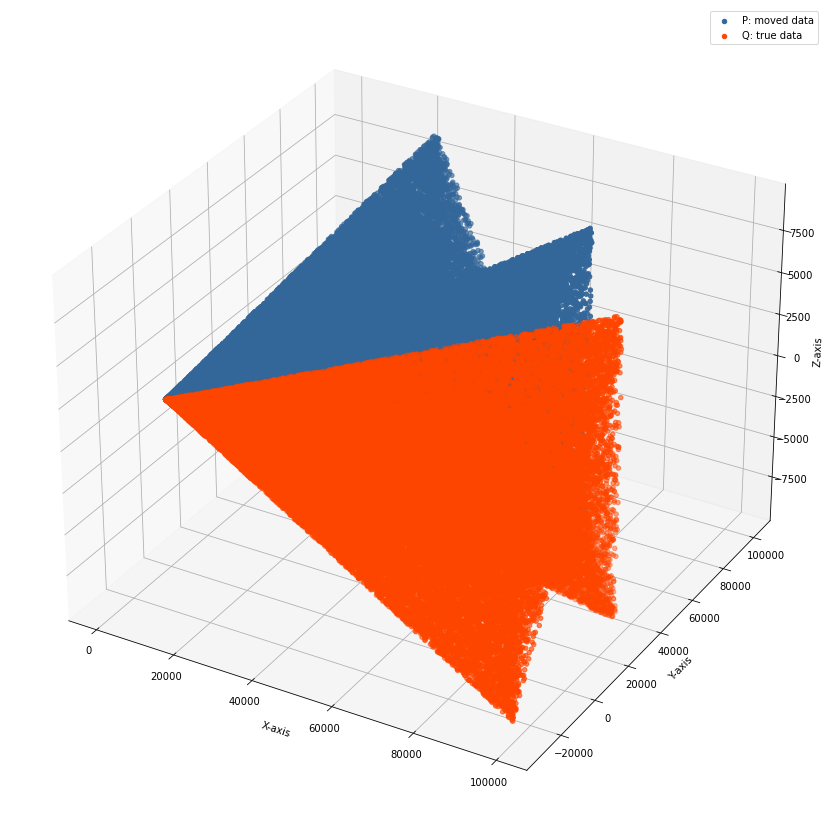

In [37]:
num_points = 100000
Q = np.zeros((3, num_points))
Q[0, :] = range(0, num_points)
Q[1, :] = .3 * Q[0, :] * np.sin(.5 * Q[0, :])
Q[2, :] = .3 * Q[1, :] * np.sin(.5 * Q[1, :])

P = R_act.dot(Q) + t_act  # moved data

plot_data(P, Q, "P: moved data", "Q: true data")
plt.ioff()
plt.show()

#### ICP Ran for 10000points

Iteration: 100%|██████████| 100/100 [10:47<00:00,  6.47s/it]


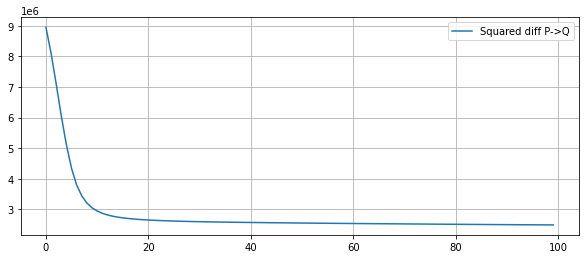

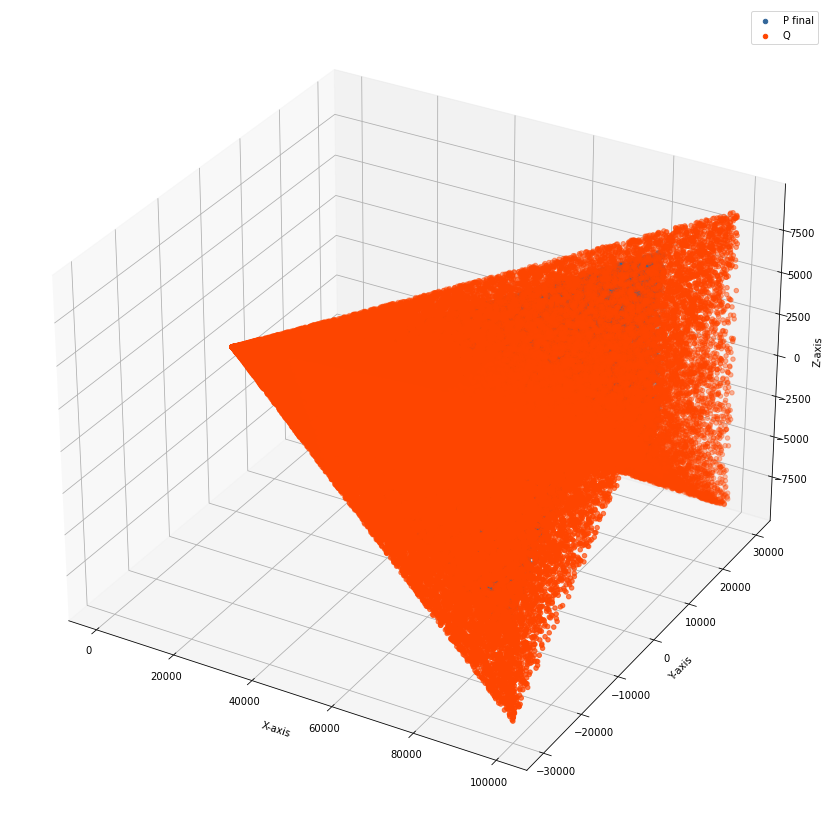

[8952583.846960213, 8103037.58082492, 7100773.53575931, 6049946.81638885, 5101941.24460604, 4338751.13790659, 3797108.6398755936, 3439489.4057953535, 3206818.349038327, 3052450.7612235467, 2947257.5497472435, 2873112.713773925, 2819296.493500133, 2779090.9047329165, 2748099.758804314, 2723517.635185874, 2703849.881610534, 2687791.8561040238, 2674365.7140767872, 2663066.777591865, 2653493.0196376396, 2645115.7600863427, 2637578.3863675296, 2630783.764461654, 2624704.8910846766, 2619190.7461566604, 2614264.946596195, 2609783.7782880757, 2605747.508321498, 2602069.84294703, 2598670.237780201, 2595372.8486687005, 2592373.6828607647, 2589579.582301254, 2586950.3044955074, 2584399.442615944, 2581965.4869475244, 2579621.884231106, 2577348.6335079926, 2575094.1942845923, 2572939.875099965, 2570894.789166815, 2568927.995790431, 2567006.1740378947, 2565192.244622869, 2563401.7991313343, 2561658.5628923643, 2559935.5662194462, 2558191.5412877556, 2556455.9731685147, 2554735.6500380873, 2552977.34

In [39]:
P_values, norm_values = icp_scale_invarant(P, Q, iterations=100)
# ax = plot_data(P_values, Q, label_1='P final', label_2='Q', markersize_1=15)
p_values , n, c = icp_svd(P_values, Q, iterations=100)
plot_values(n, label="Squared diff P->Q")
ax = plot_data(p_values[-1], Q, label_1='P final', label_2='Q', markersize_1=15)
plt.show()
print(n)

### Redwood Dataset

In [12]:
import open3d as o3d

raw_color = o3d.io.read_image("./00000.jpg")
raw_depth = o3d.io.read_image("./00000.png")

rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(raw_color, raw_depth)
pcd = o3d.geometry.PointCloud.create_from_rgbd_image(
    rgbd_image,
    o3d.camera.PinholeCameraIntrinsic(
        o3d.camera.PinholeCameraIntrinsicParameters.PrimeSenseDefault))
pcd.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])

P = np.array(np.asarray(pcd.points)).T

raw_color = o3d.io.read_image("./00004.jpg")
raw_depth = o3d.io.read_image("./00004.png")

rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(raw_color, raw_depth)
pcd = o3d.geometry.PointCloud.create_from_rgbd_image(
    rgbd_image,
    o3d.camera.PinholeCameraIntrinsic(
        o3d.camera.PinholeCameraIntrinsicParameters.PrimeSenseDefault))
pcd.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])

Q = np.array(np.asarray(pcd.points)).T

In [20]:
min_points =  min(P.shape[1], Q.shape[1])
P, Q = P[:, :min_points], Q[:, :min_points]

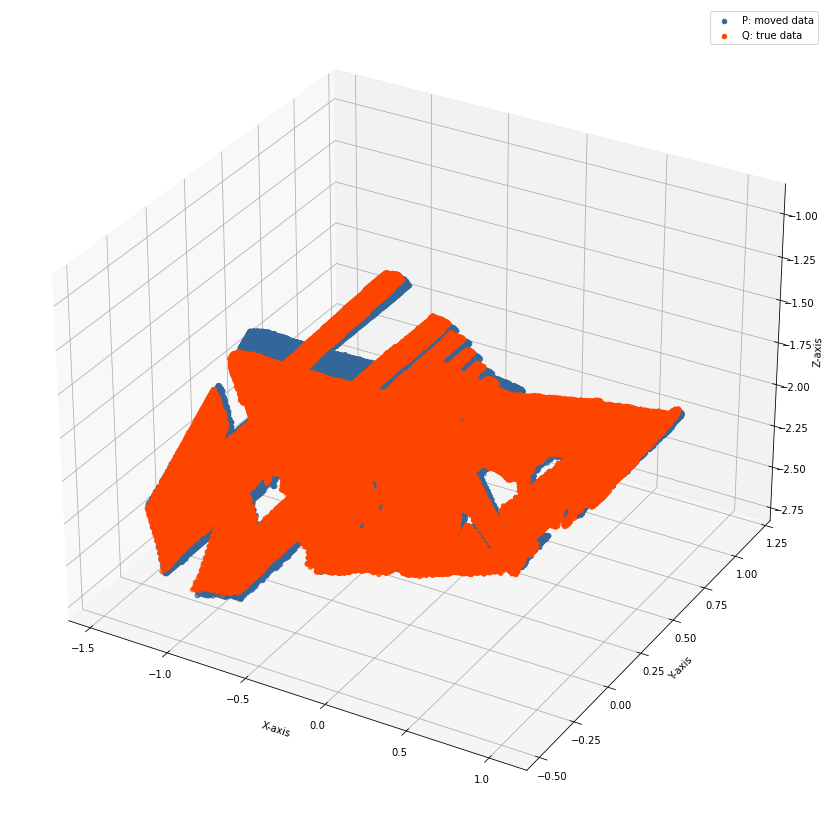

In [21]:
plot_data(P, Q, "P: moved data", "Q: true data")
plt.ioff()
plt.show()

Iteration: 100%|██████████| 20/20 [01:21<00:00,  4.06s/it]


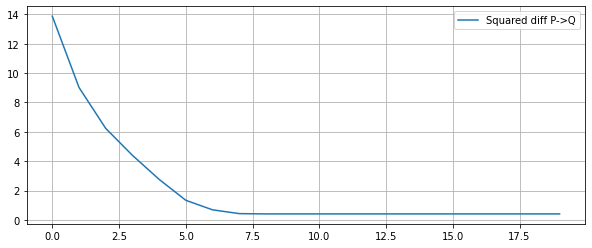

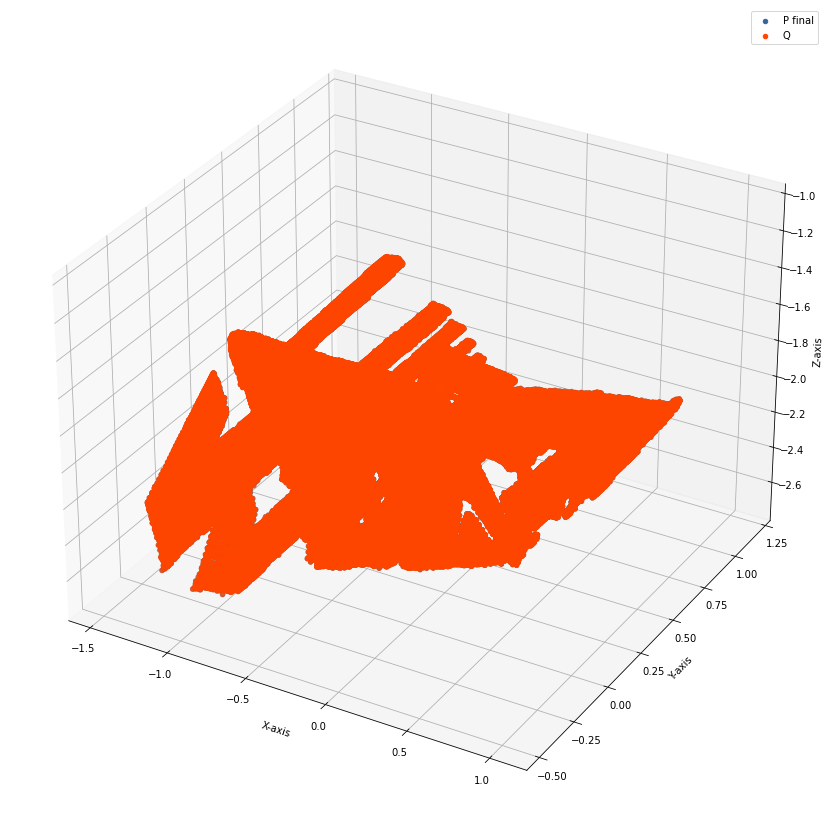

[13.874628278150864, 9.023741838708426, 6.23596564433493, 4.403074396289871, 2.7659119683908133, 1.3397699484211958, 0.690865670152498, 0.4318736160489081, 0.411666059537196, 0.4116660595369979, 0.4116660595371437, 0.4116660595370345, 0.4116660595368363, 0.4116660595366728, 0.4116660595364464, 0.41166605953637314, 0.41166605953644636, 0.4116660595364872, 0.41166605953637414, 0.41166605953632635]


In [25]:
P_values, norm_values = icp_scale_invarant(P, Q, iterations=20)
# ax = plot_data(P_values, Q, label_1='P final', label_2='Q', markersize_1=15)
p_values , n, c = icp_svd(P_values, Q, iterations=20)
plot_values(n, label="Squared diff P->Q")
ax = plot_data(p_values[-1], Q, label_1='P final', label_2='Q', markersize_1=15)
plt.show()
print(n)

### Owndatase

In [40]:
pcd_load = o3d.io.read_point_cloud("left.ply")
P = np.asarray(pcd_load.points).T

pcd_load = o3d.io.read_point_cloud("right.ply")
Q = np.asarray(pcd_load.points).T

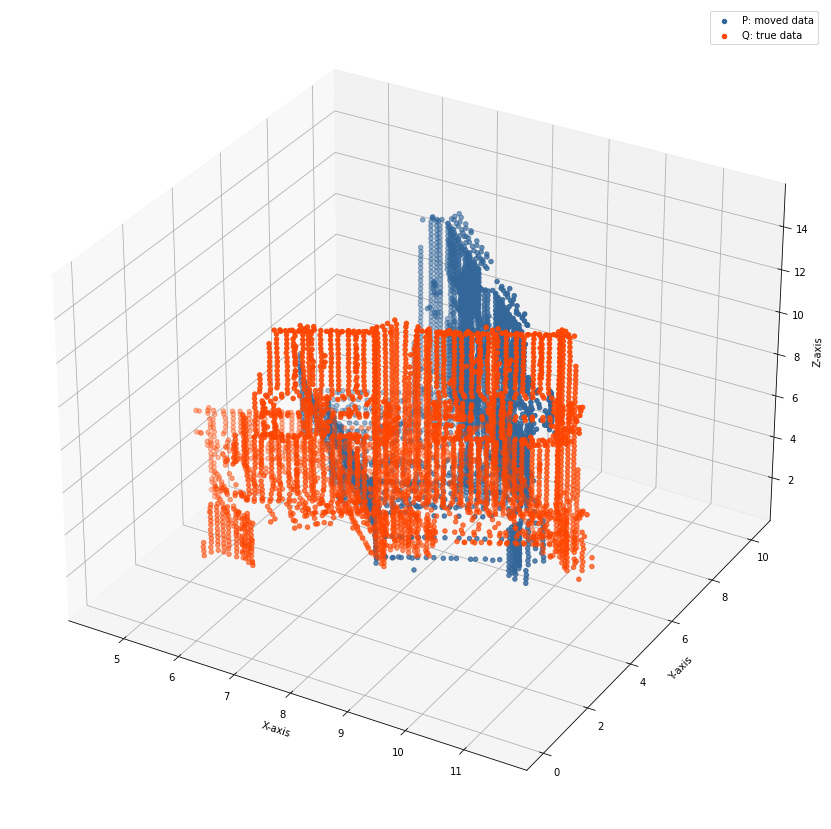

In [41]:
plot_data(P, Q, "P: moved data", "Q: true data")
plt.ioff()
plt.show()

Iteration: 100%|██████████| 20/20 [00:01<00:00, 18.58it/s]


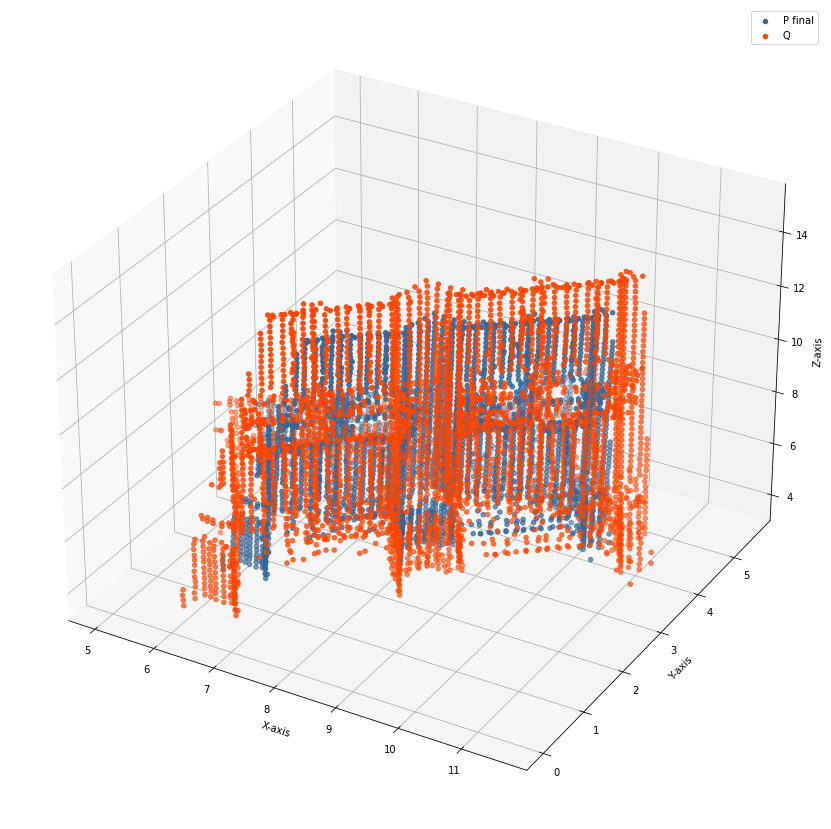

[59.727990558575776, 52.032169598404764, 48.6333160035861, 46.527700405862134, 45.037263035143305, 43.98087214508545, 43.10035458386576, 42.394206267393045, 41.805242976559, 41.292937194471136, 40.90249356481904, 40.57857883630312, 40.35045664326459, 40.18320606866252, 40.04464038893189, 39.95208114590989, 39.89018432539494, 39.84859098790893, 39.819864398618215, 39.793928254312426]


In [42]:
P_values, norm_values = icp_scale_invarant(P, Q, iterations=5)
# ax = plot_data(P_values, Q, label_1='P final', label_2='Q', markersize_1=15)
p_values , n, c = icp_svd(P_values, Q, iterations=20)
# plot_values(n, label="Squared diff P->Q")
ax = plot_data(p_values[-1], Q, label_1='P final', label_2='Q', markersize_1=15)
plt.show()
print(n)